<a href="https://colab.research.google.com/github/ucoskun/bloch-torrey-pinn/blob/main/bloch_torrey_pinn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Install deepXDE**  
Tensorflow and all other dependencies are already installed in Colab terminals

In [1]:
!pip install deepxde;
import numpy as np

import deepxde as dde
from deepxde.backend import tf
# For plotting
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

# For cleaning the messy deepXDE installation output
from IPython.display import clear_output
clear_output()


**References:**

**[1]** Kenkre et. al. Simple Solutions of the Torrey–Bloch Equations
in the NMR Study of Molecular Diffusion : https://physics.unm.edu/kenkre/papers/Art164.pdf



---

# **Solving Torrey-Bloch Equations via Physics-Informed Neural Networks (PINNs)**

Trying to reproduce the results in **[1]** using PINNs (deepxde library)

Bloch-Torrey equation for the magnetization density $M(\mathbf{r},t)$ with diffusion coefficient $D$ and arbitrary time-dependent liear gradient field is

$$M_t(\mathbf{r},t) = -igf(t)xM(\mathbf{r},t) + D\nabla^2M(\mathbf{r},t)$$

In 1-D

$$M_t(x,t) = -igf(t)xM(x,t) + D M_{xx}(x,t)$$

NMR signal is defined by

$$M(t) = \int_{-∞}^∞ M(x,t)dx$$

Denoting real and imaginary parts of $M(x,t) = u(x, t) + iv(x, t)$ we have

$$u_t - v(x, t) g f(t) x - Du_{xx}=0$$
$$v_t + u(x, t) g f(t) x - Dv_{xx}=0$$

where $f(x)$ is the envelope function of the external magnetic field.

# Case (iii) : Nonuniform Initial Density

Since we consider constant gradient we will set $f(t) = 1$.

First consider an initial square distribution

$$t\in [0, 3]$$

$$M(x, 0) = 1/L, x\in [-L/2, L/2]$$ otherwise 0.

Let's set $g=D=1$ so we have $T=(Dg^2)^{1/3}t = t$ and the parameter $p \equiv (g/D)^{1/3}L = L = 0, 2, 5, 20$.

The analytical solution is (Eq. (16) of **[1]**)
$$M(t) = \frac{\sin(tL/2)}{tL/2}e^{-t^3/3}$$

Let's plot it

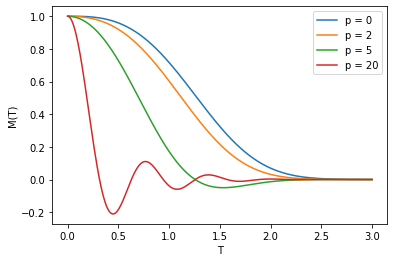

In [2]:
time = np.linspace(0.0001, 3, 300) # This time is used only for plotting the
                                   # analytical solution

def M_T(L):
    return 2*np.sin(time * L/2)/(L * time) * np.exp(-time**3 / 3)

plt.plot(time, M_T(0.0001), label = "p = 0")
plt.plot(time, M_T(2), label = "p = 2")
plt.plot(time, M_T(5), label = "p = 5")
plt.plot(time, M_T(20), label = "p = 20")

plt.xlabel("T")
plt.ylabel("M(T)")
plt.legend()

In [3]:
# Set x domain size randomly
L = 20
x_range = L/2
x_lower = -x_range
x_upper = x_range
t_lower = 0
t_upper = 3

# Creation of the 2D domain (for plotting and input, not for training!)
x_size = 5000
t_size = 300
x = np.linspace(x_lower, x_upper, x_size)
t = np.linspace(t_lower, t_upper, t_size)
X, T = np.meshgrid(x, t)

# The whole domain flattened (again only for prediction, not for training)
X_star = np.hstack((X.flatten()[:, None], T.flatten()[:, None]))

# Space and time domains/geometry (for the deepXDE model)
space_domain = dde.geometry.Interval(x_lower, x_upper)
time_domain = dde.geometry.TimeDomain(t_lower, t_upper)
geomtime = dde.geometry.GeometryXTime(space_domain, time_domain)

Text(0.5, 1.0, 'Initial condition function for $L=$20')

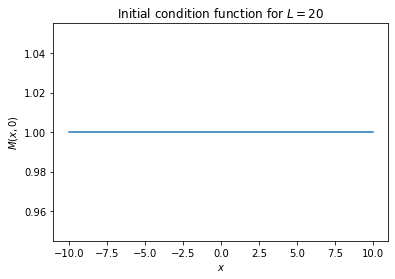

In [4]:
# Visualize the initial condition
def square_func(x):
    y = np.ones_like(x)
    y[x > L/2] = 0
    y[x < -L/2] = 0
    return y

some_domain = np.linspace(-10, 10, 100)

plt.plot(some_domain, square_func(some_domain))
plt.xlabel(r"$x$")
plt.ylabel(r"$M(x, 0)$")
plt.title(r"Initial condition function for $L=$" + str(L))


In [5]:
# The "physics-informed" part of the loss


def pde(x, y):
    """
    INPUTS:
        x: x[:,0] is x-coordinate
           x[:,1] is t-coordinate
        y: Network output, in this case:
            y[:,0] is u(x,t) the real part
            y[:,1] is v(x,t) the imaginary part
    OUTPUT:
        The pde in standard form i.e. something that must be zero
    """

    u = y[:, 0:1]
    v = y[:, 1:2]

    # In 'jacobian', i is the output component and j is the input component
    u_t = dde.grad.jacobian(y, x, i=0, j=1)
    v_t = dde.grad.jacobian(y, x, i=1, j=1)

    # In 'hessian', i and j are both input components. (The Hessian could be in principle something like d^2y/dxdt, d^2y/d^2x etc)
    # The output component is selected by "component"
    u_xx = dde.grad.hessian(y, x, component=0, i=0, j=0)
    v_xx = dde.grad.hessian(y, x, component=1, i=0, j=0)

    f_t = 1
    f_u = (u_t - v * f_t * x[:, 0:1] - u_xx)
    f_v = (v_t + u * f_t * x[:, 0:1] - v_xx)

    return [f_u, f_v]

In [6]:
# Soft Initial conditions

def init_cond_u(x):
    # Gaussian approximation of delta function
    return np.ones_like(x[:, 0:1])/L

def init_cond_v(x):
    return 0


ic_u = dde.icbc.IC(geomtime, init_cond_u, lambda _, on_initial: on_initial, component=0)
ic_v = dde.icbc.IC(geomtime, init_cond_v, lambda _, on_initial: on_initial, component=1)


In [7]:
data = dde.data.TimePDE(
    geomtime,
    pde,
    [],
    num_domain=16384,
    num_initial=0,
    train_distribution="Sobol"
)

def modify_output(x, y):
    u, v = y[:, 0:1], y[:, 1:2]
    u_new = x[:, 1:2] * u + tf.ones_like(x[:, 0:1])
    v_new = x[:, 1:2] * v
    print(u[0], v[0])
    return tf.concat((u_new, v_new), axis=1)

# Network architecture
net = dde.nn.FNN([2] + [64] * 3 + [2], "tanh", "Glorot normal")

net.apply_output_transform(modify_output)

model = dde.Model(data, net)

/usr/local/lib/python3.7/dist-packages/skopt/sampler/sobol.py:250: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+16386=16386. 
  total_n_samples))


Adam optimization.  

In [8]:
# To employ a GPU accelerated system is highly encouraged.

model.compile("adam", lr=1e-3, loss="MSE", loss_weights=[1, 1])
model.train(epochs=30000, display_every=1000)

Compiling model...
Building feed-forward neural network...
Tensor("strided_slice_5:0", shape=(1,), dtype=float32) Tensor("strided_slice_6:0", shape=(1,), dtype=float32)
'build' took 0.092086 s



/usr/local/lib/python3.7/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:110: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  kernel_constraint=self.kernel_constraint,
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/core.py:261: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)


'compile' took 1.874710 s

Initializing variables...
Training model...

Step      Train loss              Test loss               Test metric
0         [1.07e+02, 8.80e+01]    [1.07e+02, 8.80e+01]    []  
1000      [5.53e-01, 1.14e+00]    [5.53e-01, 1.14e+00]    []  
2000      [4.90e-01, 5.71e-01]    [4.90e-01, 5.71e-01]    []  
3000      [3.43e-01, 3.64e-01]    [3.43e-01, 3.64e-01]    []  
4000      [2.22e-01, 2.30e-01]    [2.22e-01, 2.30e-01]    []  
5000      [1.36e-01, 1.47e-01]    [1.36e-01, 1.47e-01]    []  
6000      [1.02e-01, 1.11e-01]    [1.02e-01, 1.11e-01]    []  
7000      [8.40e-02, 9.49e-02]    [8.40e-02, 9.49e-02]    []  
8000      [6.65e-02, 7.03e-02]    [6.65e-02, 7.03e-02]    []  
9000      [5.60e-02, 6.12e-02]    [5.60e-02, 6.12e-02]    []  
10000     [4.70e-02, 5.04e-02]    [4.70e-02, 5.04e-02]    []  
11000     [4.00e-02, 4.46e-02]    [4.00e-02, 4.46e-02]    []  
12000     [3.32e-02, 3.70e-02]    [3.32e-02, 3.70e-02]    []  
13000     [2.78e-02, 2.95e-02]    [2.78

(<deepxde.model.LossHistory at 0x7ff4ca66ce50>,
 <deepxde.model.TrainState at 0x7ff4cb2b7490>)

L-BFGS optimization.

In [9]:

dde.optimizers.config.set_LBFGS_options(
    maxcor=50,
    ftol=1.0 * np.finfo(float).eps,
    gtol=1e-08,
    maxiter=80000,
    maxfun=10000,
    maxls=50,
)
model.compile("L-BFGS")
model.train()


Compiling model...
'compile' took 0.517836 s

Training model...

Step      Train loss              Test loss               Test metric
30000     [2.79e-03, 6.33e-03]    [2.79e-03, 6.33e-03]    []  
31000     [7.03e-04, 6.85e-04]                                
32000     [3.41e-04, 3.84e-04]                                
33000     [2.30e-04, 2.25e-04]                                
34000     [1.69e-04, 1.46e-04]                                
35000     [1.34e-04, 1.01e-04]                                
36000     [1.03e-04, 8.93e-05]                                
37000     [8.35e-05, 7.35e-05]                                
38000     [6.91e-05, 5.84e-05]                                
39000     [5.91e-05, 4.77e-05]                                
40000     [4.92e-05, 4.26e-05]                                
INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT'
  Objective function value: 0.000092
  Number of iterations

(<deepxde.model.LossHistory at 0x7ff4ca66ce50>,
 <deepxde.model.TrainState at 0x7ff4cb2b7490>)

In [10]:
# Make prediction
prediction = model.predict(X_star, operator=None)

u = griddata(X_star, prediction[:, 0], (X, T), method="cubic")
v = griddata(X_star, prediction[:, 1], (X, T), method="cubic")

h = np.sqrt(u ** 2 + v ** 2)


(0.0, 3.0)

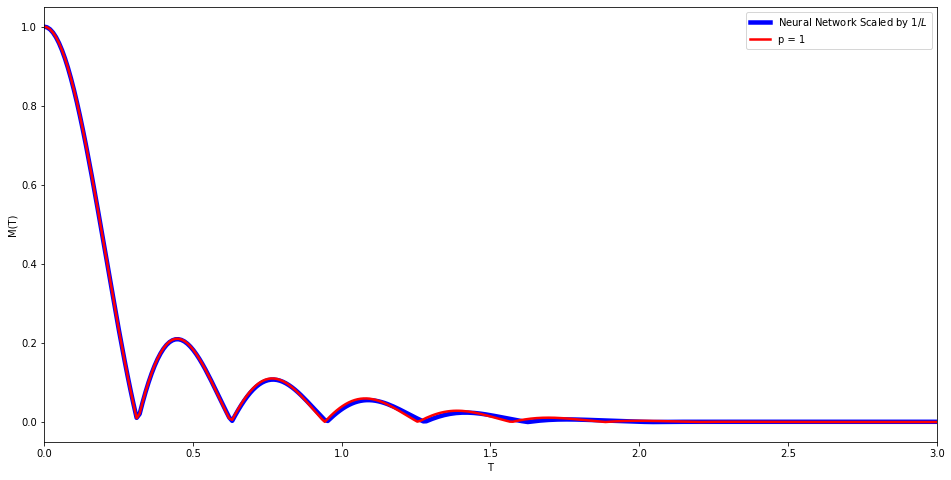

In [30]:
u_in = np.trapz(u, x= x, axis = 1)
v_in = np.trapz(v, x= x, axis = 1)

h_in = np.sqrt(u_in**2 + v_in**2)
plt.rcParams["figure.figsize"] = (16,8)
plt.plot(t, h_in/L, color="blue",linewidth=4.5, label="Neural Network Scaled by $1/L$")
plt.xlabel("T")
plt.ylabel("M(T)")
plt.plot(time, np.abs(M_T(L)), color="red",linewidth=2.5, label = "p = 1")
plt.legend()
plt.xlim(0,3)